### CNN Task

In [1]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

def get_preprocessed_data(images, targets):
    images = np.array(images / 255.0, dtype=np.float32)
    targets = np.array(targets, dtype=np.float32)
    
    return images, targets

def get_preprocessed_ohe(images, targets):
    images, targets = get_preprocessed_data(images, targets)
    oh_targets = to_categorical(targets)
    return images, oh_targets

def get_train_valid_test(train_images, train_targets, test_images, test_targets, validation_size=0.2, random_state=124):
    train_images, train_oh_targets = get_preprocessed_ohe(train_images, train_targets)
    test_images, test_oh_targets = get_preprocessed_ohe(test_images, test_targets)

    train_train_images, validation_images, train_train_oh_targets, validation_oh_targets = \
    train_test_split(train_images, train_oh_targets, stratify=train_oh_targets, test_size=validation_size, random_state=random_state)
    
    return (train_train_images, train_train_oh_targets), (validation_images, validation_oh_targets), (test_images, test_oh_targets)

In [2]:
from tensorflow.keras.datasets import mnist

(train_images, train_targets), (test_images, test_targets) = mnist.load_data()

train_images = np.reshape(train_images, (60000, 28, 28, 1))
test_images = np.reshape(test_images, (10000, 28, 28, 1))

(train_train_images, train_train_oh_targets), (validation_images, validation_oh_targets), (test_images, test_oh_targets) = \
get_train_valid_test(train_images, train_targets, test_images, test_targets)

Text(0.5, 1.0, '5')

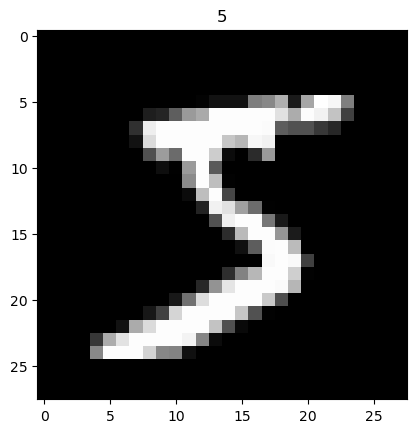

In [3]:
import matplotlib.pyplot as plt

plt.imshow(train_images[0], cmap='gray')
plt.title(train_targets[0])

In [4]:
import matplotlib.pyplot as plt

class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

def show_images(images, targets, ncols=8):
    figure, axs = plt.subplots(figsize=(22, 6), nrows=1, ncols=ncols)
    for i in range(ncols):
        axs[i].imshow(images[i], cmap='gray')
        axs[i].set_title(class_names[targets[i]])

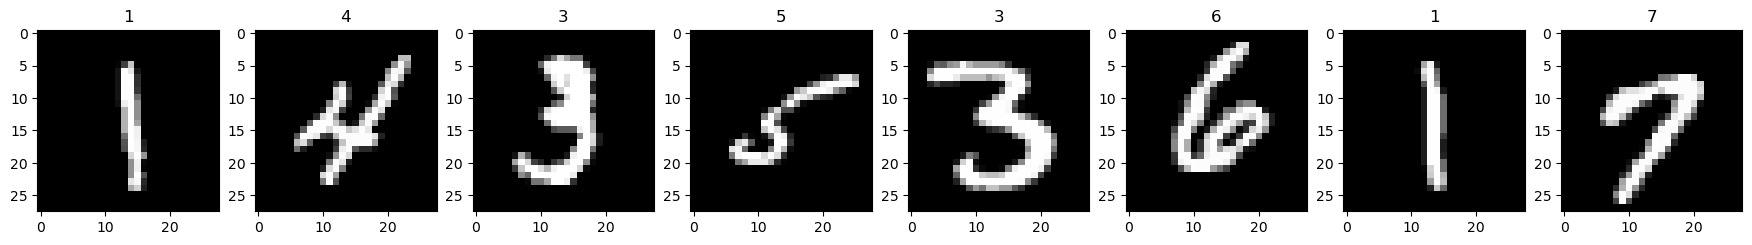

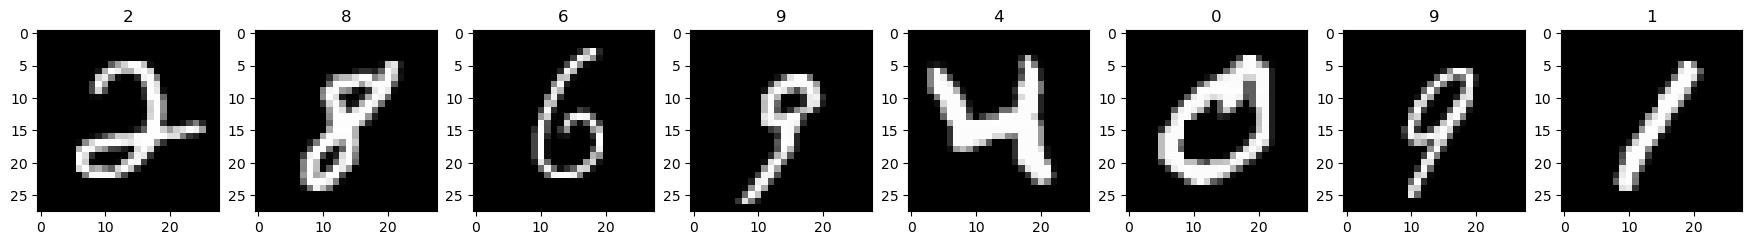

In [5]:
show_images(train_images[8:16], train_targets[8:16])
show_images(train_images[16:24], train_targets[16:24])

In [7]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy

INPUT_SIZE = 28

input_tensor = Input(shape=(INPUT_SIZE, INPUT_SIZE, 1))
x = Conv2D(filters=32, kernel_size=3, activation='relu')(input_tensor)
x = Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = MaxPooling2D(2)(x)

x = Flatten()(x)
x = Dropout(rate=0.5)(x)
x = Dense(100, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output)
model.summary()
model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['acc'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 9216)              0         
                                                                 
 dropout_1 (Dropout)         (None, 9216)              0         
                                                           

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

mcp_cb = ModelCheckpoint(
    filepath='./callback_files/weights.{epoch:02d}-{val_loss:.4f}.h5', 
    monitor='val_loss',
    save_best_only=True, 
    save_weights_only=True,
    mode='min'
)

rlr_cb = ReduceLROnPlateau(
    factor=0.2,
    patience=4, 
    monitor='val_loss',
    mode='min'
)

ely_cb = EarlyStopping(
    patience=4, 
    monitor='val_loss',
    mode='min'
)

In [9]:
history = model.fit(
    x=train_train_images,
    y=train_train_oh_targets,
    batch_size=256,
    epochs=20,
    validation_data=(validation_images, validation_oh_targets),
    callbacks=[mcp_cb, rlr_cb, ely_cb]
)

Epoch 1/20
188/188 [==============================] - 41s 212ms/step - loss: 0.2744 - acc: 0.9209 - val_loss: 0.0791 - val_acc: 0.9766 - lr: 0.0010
Epoch 2/20
188/188 [==============================] - 40s 215ms/step - loss: 0.0761 - acc: 0.9766 - val_loss: 0.0624 - val_acc: 0.9816 - lr: 0.0010
Epoch 3/20
188/188 [==============================] - 41s 220ms/step - loss: 0.0556 - acc: 0.9830 - val_loss: 0.0450 - val_acc: 0.9862 - lr: 0.0010
Epoch 4/20
188/188 [==============================] - 40s 211ms/step - loss: 0.0409 - acc: 0.9868 - val_loss: 0.0405 - val_acc: 0.9881 - lr: 0.0010
Epoch 5/20
188/188 [==============================] - 39s 207ms/step - loss: 0.0342 - acc: 0.9890 - val_loss: 0.0444 - val_acc: 0.9869 - lr: 0.0010
Epoch 6/20
188/188 [==============================] - 38s 202ms/step - loss: 0.0283 - acc: 0.9908 - val_loss: 0.0392 - val_acc: 0.9883 - lr: 0.0010
Epoch 7/20
188/188 [==============================] - 38s 202ms/step - loss: 0.0214 - acc: 0.9928 - val_loss: 0.

In [11]:
model.evaluate(test_images, test_oh_targets, batch_size=256)

40/40 [==============================] - 1s 34ms/step - loss: 0.0321 - acc: 0.9904


[0.032133132219314575, 0.9904000163078308]

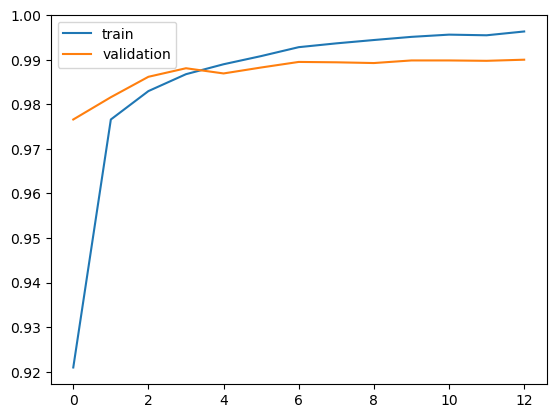

In [12]:
import matplotlib.pyplot as plt

def show_history(history):
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='validation')
    plt.legend()

show_history(history)